In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

calculating sharpe ratio for long only vs market neutral strategies

In [2]:
#download 3 years data from yfinance
# IGE_data = yf.download('IGE',start = '2021-11-30',end='2024-11-30')
# SPY_data = yf.download('SPY',start = '2021-11-30',end='2024-11-30')

In [3]:
#load ige data to csv file
# IGE_data.to_csv('IGE_3years_data_from_nov2021.csv')
# SPY_data.to_csv('SPY_3years_data_from_nov2021.csv')


In [4]:
df = pd.read_csv('datasets/IGE_3years_data_from_nov2021.csv')
df2 = pd.read_csv('datasets/SPY_3years_data_from_nov2021.csv')
df.sort_values(by='Date',inplace=True)
dailyret = df.loc[:,'Adj Close'].pct_change()#daily returns
excessRet = dailyret -0.04/252

#this is to annualize the sharpe ratio
#sqrt 252 x (average of excess return)/(standard deviation of excess return)
sharpeRatio = np.sqrt(252)*np.mean(excessRet)/np.std(excessRet)
sharpeRatio

0.6933297746079212

In [ ]:
# This ensures that the Date columns in both df and df2 are in a standard datetime format. 
# Pandas requires this format for time-based operations (like sorting and merging). 
# Without this step, the columns might remain as strings, causing errors when you try to merge or perform date-based operations.
df['Date'] = pd.to_datetime(df['Date'])
df2['Date'] = pd.to_datetime(df2['Date'])


#What is a merge? Merging combines two DataFrames (df and df2) based on a common column (Date). 
# This results in a single DataFrame where rows with matching dates from both datasets are combined.
#Suffixes: The _IGE and _SPY suffixes ensure that columns with the same name from each DataFrame are distinguished in the merged DataFrame.
#For example, both DataFrames likely have an Adj Close column, which becomes Adj Close_IGE and Adj Close_SPY.
df = pd.merge(df, df2, on='Date', suffixes=('_IGE', '_SPY'))


# Set Index: This makes the Date column the DataFrame’s index, so each row is uniquely identified by its date.
#Sort Index: Sorting ensures that the rows are ordered chronologically. 
# This is crucial for time-series analysis.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)


# pct_change: Computes the percentage change in prices from one day to the next, essentially giving the daily returns for both assets.
# dropna: The first row will have a NaN value (since there’s no previous day to calculate a percentage change), so this step removes it.
dailyret = df[['Adj Close_IGE', 'Adj Close_SPY']].pct_change().dropna()
dailyret = dailyret.rename(columns={'Adj Close_IGE': 'IGE', 'Adj Close_SPY': 'SPY'})


# Here, you are calculating the "net return" of an asset (IGE) relative to half the return of another asset (SPY). 
# This might represent a hedging strategy where you partially offset risks by "shorting" half of SPY.
netRet = dailyret['IGE'] - (dailyret['SPY'] / 2)


# Sharpe ratio
sharpeRatio = np.sqrt(252) * np.mean(netRet) / np.std(netRet)
print(f"Sharpe Ratio: {sharpeRatio}")

Calculate maximum drawdown and maximum drawdown duration

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_56884\1373123012.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  highwatermark[t] = max(highwatermark[t-1], cumret[t])
C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_56884\1373123012.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drawdown[t] = (1 + cumret[t]) / (1 + highwatermark[t]) - 1


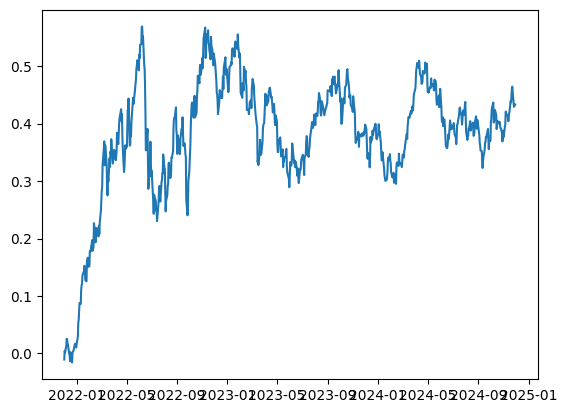

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def calculateMaxDD(cumret):
    """
    Calculates maximum drawdown (maxDD) and maximum drawdown duration (maxDDD).
    Args:
    cumret (numpy.ndarray): Array of compounded cumulative returns.

    Returns:
    maxDD (float): Maximum drawdown value.
    maxDDD (int): Maximum drawdown duration in terms of periods.
    i (int): Index of the day with the maximum drawdown.
    """
    # Initialize arrays
    highwatermark = np.zeros(cumret.shape)
    drawdown = np.zeros(cumret.shape)
    drawdownduration = np.zeros(cumret.shape)
    
    for t in np.arange(1, cumret.shape[0]):
        # Update high watermark
        highwatermark[t] = max(highwatermark[t-1], cumret[t])
        # Calculate drawdown
        drawdown[t] = (1 + cumret[t]) / (1 + highwatermark[t]) - 1
        # Update drawdown duration
        if drawdown[t] == 0:
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t-1] + 1
    
    # Get max drawdown and its details
    maxDD = np.min(drawdown)  # Drawdown is always <= 0
    i = np.argmin(drawdown)  # Day with maximum drawdown
    maxDDD = int(np.max(drawdownduration))  # Duration of max drawdown
    
    return maxDD, maxDDD, i

cumret = np.cumprod(1+netRet)-1
plt.plot(cumret)
maxDrawdown, maxDrawdownDuration, startDrawdownDay = calculateMaxDD(cumret)


In [7]:
print(f'max drawdown {maxDrawdown}')
print(f'max drawdown duration {maxDrawdownDuration}')
print(f'start draw down day {startDrawdownDay}')

max drawdown -0.21590724168704545
max drawdown duration 623
start draw down day 154


common backtesting pitfalls to avoid 

LOOK AHEAD BIAS
future information is used inappropriately to make trading decisions based on data that would not have been available at the time the trade was made.

1) Buy when the stock is within 1 percent of the day’s low"
Look-ahead bias occurs because, to determine if the stock is within 1 percent of the day's low, you would need to know the day's low, which can only be known after the market has closed.

2) "Using regression coefficients from the entire data set"
the dataset uses data from the past and future to calculate the coefficient ,but during we trade we wont know the future price ,how we can include future price into the equation for trading signal
***wouldn’t have access to future data when making decisions today.

HOW TO AVOID LOOK AHEAD BIAS
Use lagged historical data for calculating signals at every opportunity. Lagging a series of data means that you calculate all the quantities like moving averages, highs and lows, or even volume, based on data up to the close of the previous trading period only. (Of course, you needn’t lag the data if
your strategy enters only at the close of the period.)




BUT SOME LOOK AHEAD BIAS IS HARD TO AVOID
some ways to detect it

1. Run the program on the full historical data
You start with all the historical data (up to the most recent day, say day T).
Your trading strategy (backtest program) generates buy/sell positions for each day based on this data.
These positions are saved in file A.


2. Truncate your data
You now remove the most recent portion of the data from the last N days.
For example, if the last day in your original data is day T, you remove the last N days (e.g., if N is 30, you remove the last 30 days), so the new truncated data will end on day T – N.


3. Run the backtest on the truncated data
Now, you run the backtest program again using this truncated data (without the last N days).
This generates new positions for each day in the truncated data, which are saved in file B.


4. Truncate the positions file (file A)
Since file A was generated using the full historical data (which includes the last N days), you now truncate the last N rows from file A so that it matches the length of file B.
Now, both file A and file B should cover the same period (from the earliest day in the data to day T – N).


5. Compare positions in file A and B
Finally, you compare the positions in file A and file B for each day.
If both files contain identical positions, that means your backtest is free from look-ahead bias. The positions in file A (which used the full data) should be the same as the positions in file B (which used truncated data), implying that no future information was used to generate positions in file A.


DATA SNOOPING BIAS

1)overoptimized the parameters of the model based on transient noise in the historical data.Only data within the past 10 years are really suitable for building predictive model.

2)when you don’t have a lot of data, you should simplify your model by using fewer parameters to avoid overfitting and ensure that the model can generalize well to new data.
(not more than 5 parameters  including things like entry/exit thresholds, holding periods, and lookback periods for indicators like moving averages)

3)The more times you adjust the model, the more likely the Sharpe ratio will be inflated in backtesting compared to real, live trading.

HOW TO AVOID DATA SNOOPING BIAS

1)using out-of-sample testing (testing the model on data not used in training) can help ensure the model generalizes better to unseen data.
Additionally, simplifying the model and avoiding too many optimizations based on historical data can help in reducing the risk of overfitting.

2)sufficient amount of backtest data relative to the number of free parameters you want to optimize.
*** JUST FOR CONFIDENCE-for strategies with a Sharpe ratio of 1, you would need to have enough historical data (681 data points) to be confident in the validity of your results.

***FOR HIGH SHARPE RATIO-If your backtest produces a Sharpe ratio of 2 or higher, the required sample size decreases to 174 data points (about 0.7 years of daily data). 

***FOR HIGHER CONFIDENCE-  If you aim to ensure that your true Sharpe ratio is at least 1, you would need to have a backtest Sharpe ratio of 1.5 or higher, with a much larger data sample of 2,739 data points (around 10.87 years of daily data). 


OUT OF SAMPLE TESTING

divide data into test data and train data 
train data is for optimization of parameters
test data is to test the result (unseen data to the model)*** the quantity of test data can refer previous markdown

moving optimization
the model’s parameters are continually adjusted as new data becomes available, allowing the model to adapt to evolving market conditions.
***REDUCED RISK OF DATA SNOOPING BIAS

PARAMETERLESS TRADING MODEL
Dynamic Optimization- real time optimization 

Minimizing Overfitting

Parameter Averaging--use averages of parameters over a range of values. This reduces the risk of overfitting

Conditional Parameter Optimization (CPO)-- uses machine learning to determine the optimal parameters for each trade or day
